In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Read the CSV file
df = pd.read_csv('../Data/london_to_brighton_bike_ride_2025_results.csv')

In [5]:
# Function to convert time string to minutes
def time_to_minutes(time_str):
    """Convert HH:MM:SS to total minutes"""
    try:
        h, m, s = map(int, time_str.split(':'))
        return h * 60 + m + s / 60
    except:
        return np.nan

In [6]:
# Function to convert minutes to time string
def minutes_to_time(minutes):
    """Convert minutes to HH:MM:SS format"""
    hours = int(minutes // 60)
    mins = int(minutes % 60)
    secs = int((minutes % 1) * 60)
    return f"{hours:02d}:{mins:02d}:{secs:02d}"

In [7]:
# Convert times to minutes
df['total_minutes'] = df['Total'].apply(time_to_minutes)
df = df.dropna(subset=['total_minutes'])

In [8]:
# Get participant 2524 data
participant_2524 = df[df['Race Number'] == 2524]
participant_2524_time = participant_2524['total_minutes'].iloc[0] if not participant_2524.empty else None

In [9]:
# Calculate statistics
times = df['total_minutes'].values
mean_time = np.mean(times)
median_time = np.median(times)
std_time = np.std(times)
q1 = np.percentile(times, 25)
q3 = np.percentile(times, 75)

In [18]:
# Print participant 2524 analysis
if participant_2524_time:
    rank = (times < participant_2524_time).sum() + 1
    percentile = 100 - (rank / len(times) * 100)
    z_score = (participant_2524_time - mean_time) / std_time
    
    print("=" * 60)
    print("Rob's Peformance Metrics")
    print("=" * 60)
    print(f"Finish Time: {participant_2524['Total'].iloc[0]}")
    print(f"Time in Minutes: {participant_2524_time:.2f}")
    print(f"Rank: {rank:,} out of {len(times):,} participants")
    print(f"Percentile: {percentile:.1f}th (faster than {percentile:.1f}% of participants)")
    print(f"Z-score: {z_score:.2f} ({abs(z_score):.1f} std devs {'below' if z_score < 0 else 'above'} mean)")
    print(f"Time vs Mean: {participant_2524_time - mean_time:.1f} minutes {'faster' if participant_2524_time < mean_time else 'slower'}")
    print(f"Time vs Median: {participant_2524_time - median_time:.1f} minutes {'faster' if participant_2524_time < median_time else 'slower'}")
    
    # Quartile analysis
    if participant_2524_time < q1:
        quartile = "1st (top 25%)"
    elif participant_2524_time < median_time:
        quartile = "2nd (25-50%)"
    elif participant_2524_time < q3:
        quartile = "3rd (50-75%)"
    else:
        quartile = "4th (bottom 25%)"
    
    print(f"Quartile: {quartile}")
    
    # Time categories
    sub_3h = (times < 180).sum()
    sub_4h = (times < 240).sum()
    sub_5h = (times < 300).sum()
    
    print(f"\nSub-3 hour finishers: {sub_3h:,} ({sub_3h/len(times)*100:.1f}%)")
    print(f"Sub-4 hour finishers: {sub_4h:,} ({sub_4h/len(times)*100:.1f}%)")
    print(f"Sub-5 hour finishers: {sub_5h:,} ({sub_5h/len(times)*100:.1f}%)")
    
    category = ""
    if participant_2524_time < 180:
        category = "Sub-3 hour (Elite)"
    elif participant_2524_time < 240:
        category = "Sub-4 hour (Excellent)"
    elif participant_2524_time < 300:
        category = "Sub-5 hour (Good)"
    else:
        category = "5+ hours (Recreational)"
    
    print(f"Rob's Category: {category}")


Rob's Peformance Metrics
Finish Time: 03:25:32
Time in Minutes: 205.53
Rank: 317 out of 8,644 participants
Percentile: 96.3th (faster than 96.3% of participants)
Z-score: -1.35 (1.3 std devs below mean)
Time vs Mean: -131.9 minutes faster
Time vs Median: -125.8 minutes faster
Quartile: 1st (top 25%)

Sub-3 hour finishers: 92 (1.1%)
Sub-4 hour finishers: 974 (11.3%)
Sub-5 hour finishers: 3,013 (34.9%)
Rob's Category: Sub-4 hour (Excellent)


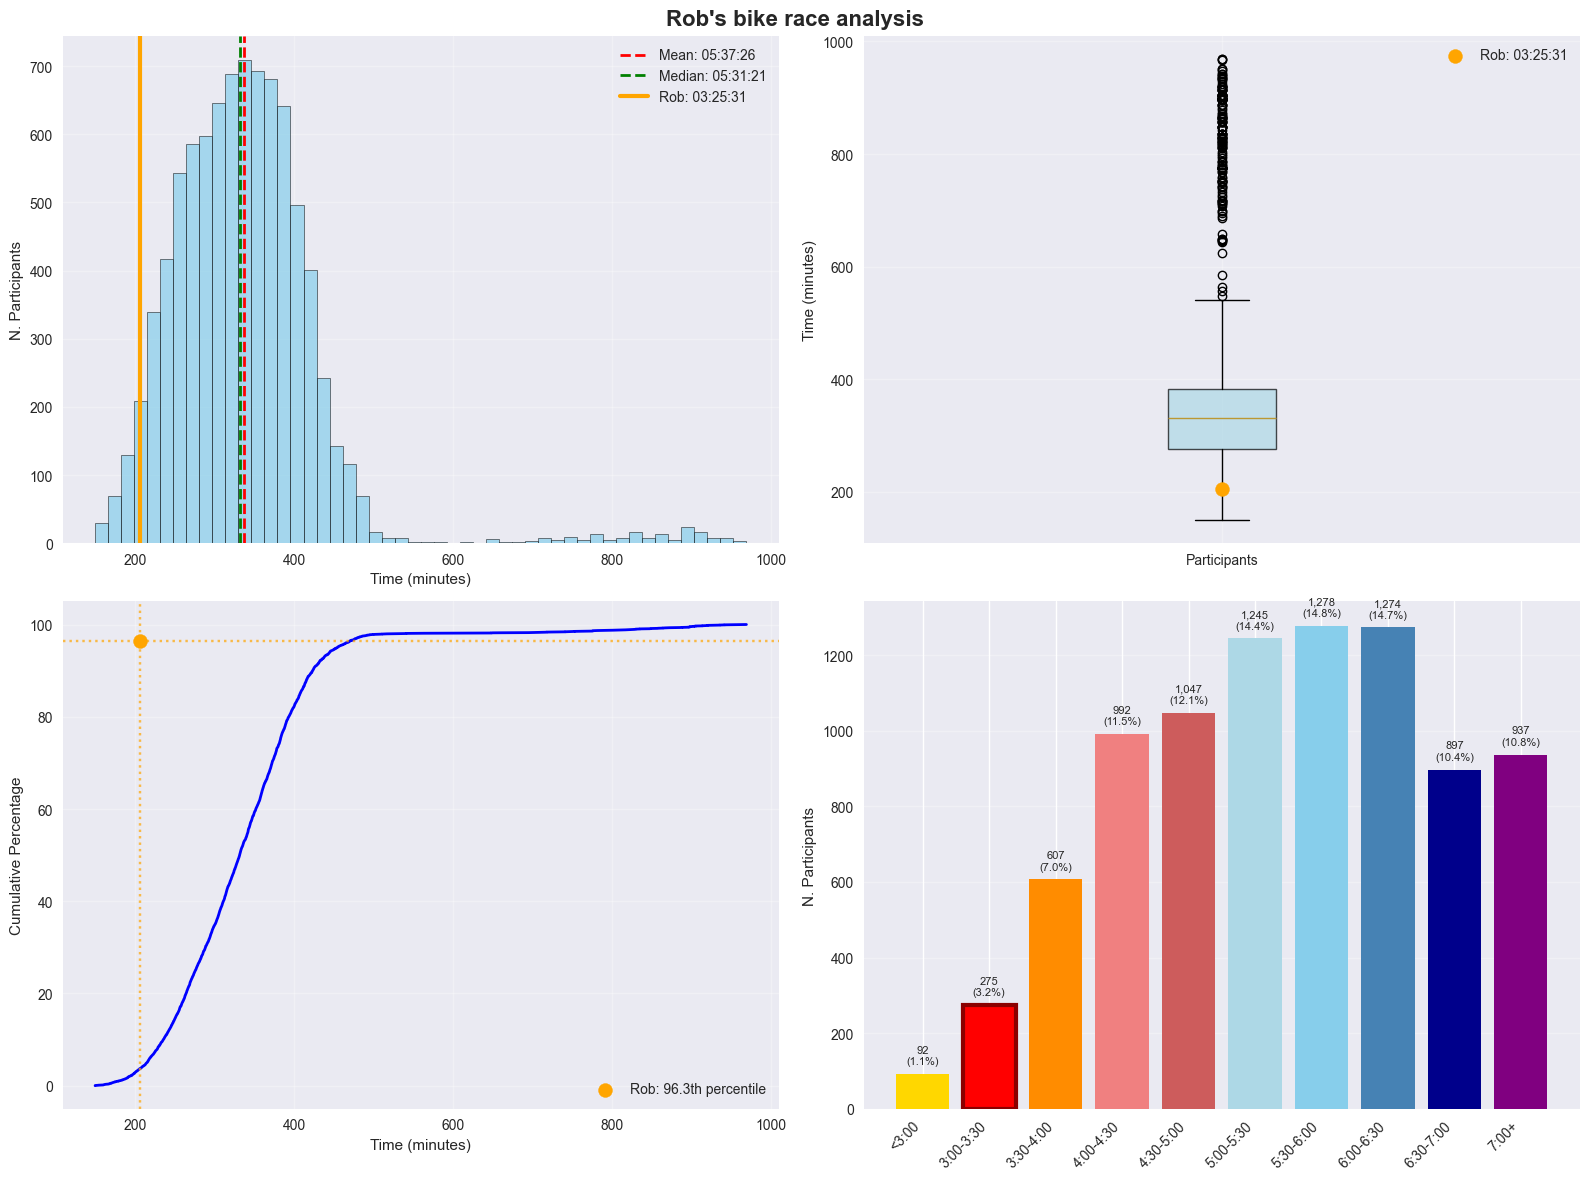

In [17]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Rob's bike race analysis", fontsize=16, fontweight='bold')

# 1. Histogram with key statistics
ax1 = axes[0, 0]
n, bins, patches = ax1.hist(times, bins=50, alpha=0.7, color='skyblue', edgecolor='black', linewidth=0.5)
ax1.axvline(mean_time, color='red', linestyle='--', linewidth=2, label=f'Mean: {minutes_to_time(mean_time)}')
ax1.axvline(median_time, color='green', linestyle='--', linewidth=2, label=f'Median: {minutes_to_time(median_time)}')
if participant_2524_time:
    ax1.axvline(participant_2524_time, color='orange', linestyle='-', linewidth=3, 
               label=f'Rob: {minutes_to_time(participant_2524_time)}')
ax1.set_xlabel('Time (minutes)')
ax1.set_ylabel('N. Participants')
#ax1.set_title('Distribution of Finish Times')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Box plot with participant 2524 highlighted
ax2 = axes[0, 1]
bp = ax2.boxplot(times, vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][0].set_alpha(0.7)
if participant_2524_time:
    ax2.scatter(1, participant_2524_time, color='orange', s=100, zorder=5, 
               label=f'Rob: {minutes_to_time(participant_2524_time)}')
ax2.set_ylabel('Time (minutes)')
#ax2.set_title('Box Plot of Finish Times')
ax2.set_xticklabels(['Participants'])
if participant_2524_time:
    ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Cumulative distribution
ax3 = axes[1, 0]
sorted_times = np.sort(times)
cumulative_pct = np.arange(1, len(sorted_times) + 1) / len(sorted_times) * 100
ax3.plot(sorted_times, cumulative_pct, color='blue', linewidth=2)
if participant_2524_time:
    participant_percentile = 100 - (rank / len(times) * 100)
    ax3.scatter(participant_2524_time, participant_percentile, color='orange', s=100, zorder=5,
               label=f'Rob: {participant_percentile:.1f}th percentile')
    ax3.axhline(participant_percentile, color='orange', linestyle=':', alpha=0.7)
    ax3.axvline(participant_2524_time, color='orange', linestyle=':', alpha=0.7)
ax3.set_xlabel('Time (minutes)')
ax3.set_ylabel('Cumulative Percentage')
#ax3.set_title('Cumulative Distribution of Finish Times')
ax3.grid(True, alpha=0.3)
if participant_2524_time:
    ax3.legend()

# 4. Time categories bar chart (30-minute intervals)
ax4 = axes[1, 1]
categories = ['<3:00', '3:00-3:30', '3:30-4:00', '4:00-4:30', '4:30-5:00', 
              '5:00-5:30', '5:30-6:00', '6:00-6:30', '6:30-7:00', '7:00+']
counts = [
    (times < 180).sum(),                           # Sub-3:00
    ((times >= 180) & (times < 210)).sum(),       # 3:00-3:30
    ((times >= 210) & (times < 240)).sum(),       # 3:30-4:00
    ((times >= 240) & (times < 270)).sum(),       # 4:00-4:30
    ((times >= 270) & (times < 300)).sum(),       # 4:30-5:00
    ((times >= 300) & (times < 330)).sum(),       # 5:00-5:30
    ((times >= 330) & (times < 360)).sum(),       # 5:30-6:00
    ((times >= 360) & (times < 390)).sum(),       # 6:00-6:30
    ((times >= 390) & (times < 420)).sum(),       # 6:30-7:00
    (times >= 420).sum()                          # 7:00+
]

# Use a gradient of colors for visual appeal
colors = ['gold', 'orange', 'darkorange', 'lightcoral', 'indianred', 
          'lightblue', 'skyblue', 'steelblue', 'darkblue', 'purple']
bars = ax4.bar(categories, counts, color=colors)

# Highlight participant 2524's category
if participant_2524_time:
    if participant_2524_time < 180:
        highlight_idx = 0
    elif participant_2524_time < 210:
        highlight_idx = 1
    elif participant_2524_time < 240:
        highlight_idx = 2
    elif participant_2524_time < 270:
        highlight_idx = 3
    elif participant_2524_time < 300:
        highlight_idx = 4
    elif participant_2524_time < 330:
        highlight_idx = 5
    elif participant_2524_time < 360:
        highlight_idx = 6
    elif participant_2524_time < 390:
        highlight_idx = 7
    elif participant_2524_time < 420:
        highlight_idx = 8
    else:
        highlight_idx = 9
    
    bars[highlight_idx].set_color('red')
    bars[highlight_idx].set_edgecolor('darkred')
    bars[highlight_idx].set_linewidth(3)

ax4.set_ylabel('N. Participants')
#ax4.set_title('Participants by 30-Minute Time Intervals')
ax4.grid(True, alpha=0.3, axis='y')
plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')

# Add percentages on bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    percentage = count / len(times) * 100
    if count > 0:  # Only show labels for categories with participants
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                 f'{count:,}\n({percentage:.1f}%)', 
                 ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('../Figures/london_to_brighton_bike_ride_2025_analysis.png', dpi=300)
plt.show()

In [15]:
# Print summary statistics
print("\n" + "=" * 60)
print("OVERALL RACE STATISTICS")
print("=" * 60)
print(f"Total Participants: {len(times):,}")
print(f"Mean Time: {minutes_to_time(mean_time)} ({mean_time:.2f} minutes)")
print(f"Median Time: {minutes_to_time(median_time)} ({median_time:.2f} minutes)")
print(f"Standard Deviation: {std_time:.2f} minutes")
print(f"Fastest Time: {minutes_to_time(np.min(times))}")
print(f"Slowest Time: {minutes_to_time(np.max(times))}")
print(f"Q1 (25th percentile): {minutes_to_time(q1)}")
print(f"Q3 (75th percentile): {minutes_to_time(q3)}")
print(f"IQR: {q3 - q1:.2f} minutes")


OVERALL RACE STATISTICS
Total Participants: 8,644
Mean Time: 05:37:26 (337.44 minutes)
Median Time: 05:31:21 (331.36 minutes)
Standard Deviation: 97.95 minutes
Fastest Time: 02:29:35
Slowest Time: 16:08:58
Q1 (25th percentile): 04:35:40
Q3 (75th percentile): 06:22:33
IQR: 106.88 minutes
